<a href="https://colab.research.google.com/github/tjann/api-python/blob/udpatenb/Case_Study_Analyzing_Income_Distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2020 Google LLC.
SPDX-License-Identifier: Apache-2.0

**Notebook Version** - 1.0.1

In [1]:
# Install datacommons
!pip install datacommons --upgrade --quiet

# Analyzing Income Distribution

The American Community Survey (published by the US Census) annually reports the number of individuals in a given income bracket at the State level. We can use this information, stored in Data Commons, to visualize disparity in income for each State in the US. Our goal for this tutorial will be to generate a plot that visualizes the total number of individuals across a given set of income brackets for a given state. 

Before we begin, we'll setup our notebook.

In [2]:
# Import the Data Commons library
import datacommons as dc

# Import other libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


## Preparing the Data

We'll begin by creating a dataframe with states and their total population. We can use **`get_places_in`** to get all States within the United States. We can then call **`get_stats`** to get the population of each State.

In [3]:
# Initialize a DataFrame holding the states
data = pd.DataFrame({'state': dc.get_places_in(['country/USA'], 'State')['country/USA']})

# Get all state names and store it in a column "name"
# Get the first name, if there are multiple for a state
data['name'] = data['state'].map(dc.get_property_values(data['state'], 'name')).str[0]

# Get the total count of all persons for each state
data['Count_Person'] = data['state'].map(dc.get_stats(data['state'], "Count_Person", ['2017']))

# Extract just the number for population
get_value = lambda row: row.get('data').get('2017')
data['Count_Person'] = data['Count_Person'].apply(get_value).dropna()

# Display the first five rows of the table
data.head(5)

,state,name,Count_Person
0,geoId/01,Alabama,4874486
1,geoId/02,Alaska,739700
2,geoId/04,Arizona,7044008
3,geoId/05,Arkansas,3001345
4,geoId/06,California,39358497


### Querying for Income Brackets

Next, let's get the population level for each income bracket. The datacommons graph identifies 16 different income brackets. For each bracket and state, we can get the observations directly by calling **`get_stats`**. We'll filter observations to between published in 2017 by the American Community Survey. Note these StatisticalVariables can be found [here](http://docs.datacommons.org/statistical_variables.html).

In [4]:
# A list of income bracket StatisticalVariables
income_brackets = [
  "Count_Household_IncomeOfUpto10000USDollar",
  "Count_Household_IncomeOf10000To14999USDollar",
  "Count_Household_IncomeOf15000To19999USDollar",
  "Count_Household_IncomeOf20000To24999USDollar",
  "Count_Household_IncomeOf25000To29999USDollar",
  "Count_Household_IncomeOf30000To34999USDollar",
  "Count_Household_IncomeOf35000To39999USDollar",
  "Count_Household_IncomeOf40000To44999USDollar",
  "Count_Household_IncomeOf45000To49999USDollar",
  "Count_Household_IncomeOf50000To59999USDollar",
  "Count_Household_IncomeOf60000To74999USDollar",
  "Count_Household_IncomeOf75000To99999USDollar",
  "Count_Household_IncomeOf100000To124999USDollar",
  "Count_Household_IncomeOf125000To149999USDollar",
  "Count_Household_IncomeOf150000To199999USDollar",
  "Count_Household_IncomeOf200000OrMoreUSDollar",
]

# Add a column containing the population count for each income bracket
for bracket in income_brackets:
  # Get the StatVarObservations
  data[bracket] = data['state'].map(dc.get_stats(data['state'], bracket, ['2017'])).apply(get_value).dropna()

# Display the table
data.head(5)

,state,name,Count_Person,Count_Household_IncomeOfUpto10000USDollar,Count_Household_IncomeOf10000To14999USDollar,Count_Household_IncomeOf15000To19999USDollar,Count_Household_IncomeOf20000To24999USDollar,Count_Household_IncomeOf25000To29999USDollar,Count_Household_IncomeOf30000To34999USDollar,Count_Household_IncomeOf35000To39999USDollar,Count_Household_IncomeOf40000To44999USDollar,Count_Household_IncomeOf45000To49999USDollar,Count_Household_IncomeOf50000To59999USDollar,Count_Household_IncomeOf60000To74999USDollar,Count_Household_IncomeOf75000To99999USDollar,Count_Household_IncomeOf100000To124999USDollar,Count_Household_IncomeOf125000To149999USDollar,Count_Household_IncomeOf150000To199999USDollar,Count_Household_IncomeOf200000OrMoreUSDollar
0,geoId/01,Alabama,4874486,170650,121688,116273,112406,102590,100223,92139,88987,76070,149492,176589,206436,133618,76939,71748,60847
1,geoId/02,Alaska,739700,9650,7838,8013,8854,8383,8914,8998,10163,8536,18810,26224,36745,29925,19752,23596,18135
2,geoId/04,Arizona,7044008,178384,118676,123075,131903,127741,127570,119431,125103,107245,208318,254294,303811,200818,119347,119778,116817
3,geoId/05,Arkansas,3001345,97226,78535,74451,75194,70211,67958,61588,60814,50978,95836,111618,120034,72752,40780,35900,33416
4,geoId/06,California,39358497,694945,604666,536203,568994,523563,539988,500571,509113,456152,895758,1199773,1568843,1206637,818690,1008388,1255844


## Analyzing the Data

Let's plot our data as a histogram. **Notice that the income ranges as tabulated by the US Census are not equal.** At the low end, the range is 0-9999, whereas, towards the top, the range 150,000-199,999 is five times as broad! **We will make the width of each of the columns correspond to their range, and will give us an idea of the total earnings, not just the number of people in that group.**

First we provide code for generating the plot.

In [5]:
# Bar chart endpoints (for calculating bar width)
label_to_range = {
  "Count_Household_IncomeOfUpto10000USDollar": [0, 9999],
  "Count_Household_IncomeOf10000To14999USDollar": [10000, 14999],
  "Count_Household_IncomeOf15000To19999USDollar": [15000, 19999],
  "Count_Household_IncomeOf20000To24999USDollar": [20000, 24999],
  "Count_Household_IncomeOf25000To29999USDollar": [25000, 29999],
  "Count_Household_IncomeOf30000To34999USDollar": [30000, 34999],
  "Count_Household_IncomeOf35000To39999USDollar": [35000, 39999],
  "Count_Household_IncomeOf40000To44999USDollar": [40000, 44999],
  "Count_Household_IncomeOf45000To49999USDollar": [45000, 49999],
  "Count_Household_IncomeOf50000To59999USDollar": [50000, 59999],
  "Count_Household_IncomeOf60000To74999USDollar": [60000, 74999],
  "Count_Household_IncomeOf75000To99999USDollar": [75000, 99999],
  "Count_Household_IncomeOf100000To124999USDollar": [100000, 124999],
  "Count_Household_IncomeOf125000To149999USDollar": [125000, 149999],
  "Count_Household_IncomeOf150000To199999USDollar": [150000, 199999],
  "Count_Household_IncomeOf200000OrMoreUSDollar": [200000, 300000],
}

def plot_income(data, state_name):
  # Assert that specified "state_name" is a valid state name
  frame_search = data.loc[data['name'] == state_name].squeeze()
  if frame_search.shape[0] == 0:
    print('{} does not have sufficient income data to generate the plot!'.format(state_name))
    return
  
  # Print the resulting series
  data = frame_search[2:]

  # Calculate the lengths without intervals
  widths_without_interval = []
  for bracket in income_brackets:
    r = label_to_range[bracket] 
    widths_without_interval.append(int((r[1] - r[0]) / 18))

  # Calculate the x-axis positions
  pos, total = [], 0
  for l in widths_without_interval:
    pos.append(total + (l // 2))
    total += l

  # Calculate the bar lengths
  widths = []
  for bracket in income_brackets:
    r = label_to_range[bracket] 
    # 50 here to be the intervals between bars
    widths.append(int((r[1] - r[0]) / 18 - 50))

  # Plot the histogram
  plt.figure(figsize=(12, 10))
  plt.xticks(pos, income_brackets, rotation=90)
  plt.grid(True)
  plt.bar(pos, data.values, widths, color='b', alpha=0.3)

  # Return the resulting frame.
  return frame_search

We can then call this code with a state to plot the income bracket sizes.

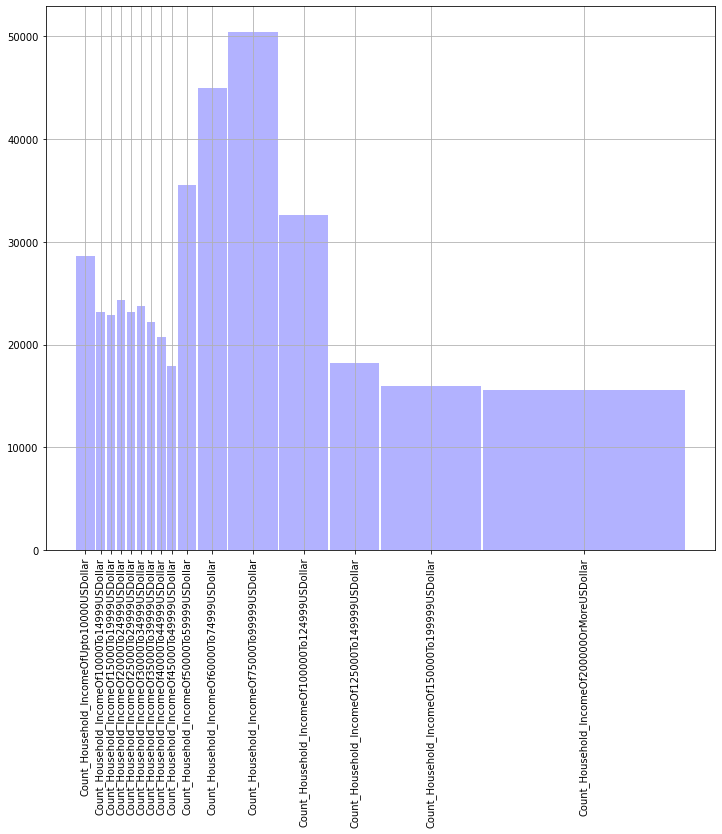

In [6]:
#@title Enter State to plot { run: "auto" }
state_name = "Montana" #@param ["Missouri", "Arkansas", "Arizona", "Ohio", "Connecticut", "Vermont", "Illinois", "South Dakota", "Iowa", "Oklahoma", "Kansas", "Washington", "Oregon", "Hawaii", "Minnesota", "Idaho", "Alaska", "Colorado", "Delaware", "Alabama", "North Dakota", "Michigan", "California", "Indiana", "Kentucky", "Nebraska", "Louisiana", "New Jersey", "Rhode Island", "Utah", "Nevada", "South Carolina", "Wisconsin", "New York", "North Carolina", "New Hampshire", "Georgia", "Pennsylvania", "West Virginia", "Maine", "Mississippi", "Montana", "Tennessee", "New Mexico", "Massachusetts", "Wyoming", "Maryland", "Florida", "Texas", "Virginia"]
result = plot_income(data.drop('state', axis=1), state_name)

# Show the plot
plt.show()

and we can display the raw table of values.

In [7]:
# Additionally print the table of income bracket sizes 
result

name                                              Montana
Count_Person                                      1052482
Count_Household_IncomeOfUpto10000USDollar           28634
Count_Household_IncomeOf10000To14999USDollar        23152
Count_Household_IncomeOf15000To19999USDollar        22896
Count_Household_IncomeOf20000To24999USDollar        24321
Count_Household_IncomeOf25000To29999USDollar        23155
Count_Household_IncomeOf30000To34999USDollar        23776
Count_Household_IncomeOf35000To39999USDollar        22173
Count_Household_IncomeOf40000To44999USDollar        20708
Count_Household_IncomeOf45000To49999USDollar        17897
Count_Household_IncomeOf50000To59999USDollar        35490
Count_Household_IncomeOf60000To74999USDollar        44956
Count_Household_IncomeOf75000To99999USDollar        50409
Count_Household_IncomeOf100000To124999USDollar      32624
Count_Household_IncomeOf125000To149999USDollar      18244
Count_Household_IncomeOf150000To199999USDollar      15964
Count_Househol

This is only the beginning! What else can you analyze? For example, you could try computing a measure of income disparity in each state (see [Gini Coefficient](https://en.wikipedia.org/wiki/Gini_coefficient)).

You could then expand the dataframe to include more information and analyze how attributes like education level, crime, or even weather affect income disparity.

